# CNS Laboratory 3.2

Author: Luca Moroni

In [25]:
# create the folder in which i will save the stuffs
# images folder
!mkdir Images

# saved object folder
!mkdir Objects

mkdir: cannot create directory ‘Images’: File exists
mkdir: cannot create directory ‘Objects’: File exists


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import figure
import itertools
import random
import pickle
from pathlib import Path

Function definitions

In [27]:
def active_reproducibility(manual_seed=42):
  """
    Function that set random seeds for every used library.
  """

  random.seed(manual_seed)
  np.random.seed(manual_seed)


def multiple_eval(model_args, X_train, y_train, X_valid, y_valid, num_trials=5):
  """
    Train and evaluate multiple times EchoStateNetwork wiht model_args arguments.
    The model is trained over (X_train, y_train) data and validated|tested over
    (X_valid, y_valid) data. The train, valid errors (MSE) are averaged over
    num_trials runs.
  """

  train_loss = 0
  valid_loss = 0

  for _ in range(num_trials):
    esn = EchoStateNetwork(1, **model_args)
    
    esn.train(X_train, y_train)

    _, h_train = esn.predict(X_train)

    tr_loss, h_train = esn.evaluate(X_train, y_train)
    vl_loss, _ = esn.evaluate(X_valid, y_valid, h_train)

    train_loss += tr_loss
    valid_loss += vl_loss

  return train_loss/num_trials, valid_loss/num_trials


def grid_search(grid, X_train, y_train, X_valid, y_valid):
  """
  Grid search the best parameters of the model, the parameters are get out from
  the grid dictionary, iterating over all the possible combination of the values
  in it.
  """
  
  best_valid_loss = np.inf
  best_params = None
  best_train_loss = None
  
  for args_comb in itertools.product(*grid.values()):

    train_args = {k:v for (k, v) in zip(list(grid.keys()), args_comb)}

    train_loss, valid_loss = multiple_eval(train_args, X_train, y_train, X_valid, y_valid)
    
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      best_params = train_args
      best_train_loss = train_loss

    print(" -- finished", train_args, "train loss", train_loss,"valid loss", valid_loss)
          
  print("finished grid search, the best are:", best_params, "with a loss of: ", best_valid_loss)
      
  return best_train_loss, best_valid_loss, best_params

Echo State Network

In [28]:
class EchoStateNetwork():
  """
    Echo State Network implementation.
    Implementing the training, the forward and the evalutation methods.
  """

  def __init__(self, input_dim=1, hidden_dim=10, spectral_radius=0.5, delta_x=0.4, delta_b=0.4, transient_lenght=10, lambda_reg=0):
    self.input_dim = input_dim

    # input weights, generate random matrix whose values lies in [-delta_x, delta_x]
    self.W_x = (np.random.rand(input_dim, hidden_dim)*2 - 1)*delta_x

    # input bias, generate random vector whose values lies in [-delta_b, delta_b]
    self.b = (np.random.rand(hidden_dim)*2 - 1)*delta_b

    # initialization of the recurrent weight matrix
    self.W_h = np.random.rand(hidden_dim, hidden_dim)*2 - 1 # values in [-1, 1]
    # get the spectrum
    spectrum = np.max(np.abs(np.linalg.eigvals(self.W_h)))

    self.W_h = (self.W_h/spectrum) * spectral_radius # adjust the spectral radius

    self.transient_lenght = transient_lenght
    self.hidden_dim = hidden_dim

    self.lambda_reg = lambda_reg

    self.W_o = None

  def _compute_hidden_states(self, data, hidden_state, training):
    """
      compute the hidden states given data values, and an initial hidden state.
      In training (=True) phase the method remove the transient elements.
    """
    
    hidden_states = []

    for i, data_i in enumerate(data):
      hidden_state = np.tanh(hidden_state@self.W_h + data_i@self.W_x + self.b)

      if i >= self.transient_lenght or not training:
        hidden_states.append(hidden_state.copy())
    
    hidden_states = np.array(hidden_states)

    # add bias
    hidden_states = np.concatenate([np.array(hidden_states), np.ones((hidden_states.shape[0], 1))], axis=1)

    return hidden_states


  def train(self, data, target):
    """
      Training method, train the model over the (data, target) pair.
    """

    # compute the reservoir states
    hidden_state = np.zeros(self.hidden_dim)

    if len(data.shape) == 1:
      data = np.expand_dims(data, axis=1)

    if len(target.shape) == 1:
      target = np.expand_dims(target, axis=1)

    hidden_states = self._compute_hidden_states(data, hidden_state, True)

    # compute the readout
    self.W_o = target[self.transient_lenght:].T@hidden_states@np.linalg.inv(hidden_states.T@hidden_states + self.lambda_reg*np.eye(self.hidden_dim+1))

  def predict(self, data, hidden_state=None):
    """
      Predict the output given the data elements.
      If the parameter hidden_state is given the hidden states are computed started
      from it.
    """

    if hidden_state is None:
      hidden_state = np.zeros(self.hidden_dim)

    to_squeeze = False

    if len(data.shape) == 1:
      to_squeeze = True
      data = np.expand_dims(data, axis=1)

    hidden_states = self._compute_hidden_states(data, hidden_state, False)

    output = hidden_states@self.W_o.T

    if to_squeeze:
      output = np.squeeze(output, 1)
    
    # return output and last hidden_state
    return output, hidden_states[-1, :-1] # remove bias 
    # return output, hidden_states[-1]

  def evaluate(self, data, target, hidden_state=None):
    """
      Evaluate the model over the (data, target) pair.
      If the hidden_state is not none the model is assumed to be in a valid|test phase,
      so in this case the transient_lenght elements are removed from the MSE computation.
    """

    pred, h_pred = self.predict(data, hidden_state)

    if hidden_state is None:
      pred = pred[self.transient_lenght:]
      target = target[self.transient_lenght:]

    # return MSE and the hidden state of the prediction 
    return (np.square(pred - target)).mean(), h_pred

In [29]:
def save_stuffs(model, path):
  """
    Save model into disk at path location
  """

  with open(path, "wb") as f:
    pickle.dump(model, f)

  
def load_stuffs(path):
  """
    Load model from disk at path location
  """

  with open(path, "rb") as f:
    model = pickle.load(f)

  return model

In [30]:
# active the reproducibiliy
active_reproducibility()

## NARMA10

In [31]:
data_narma10 = pd.read_csv("data/NARMA10.csv", header=None)

In [32]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [33]:
NARMA10_X = data_narma10.values[0, :]
NARMA10_y = data_narma10.values[1, :]

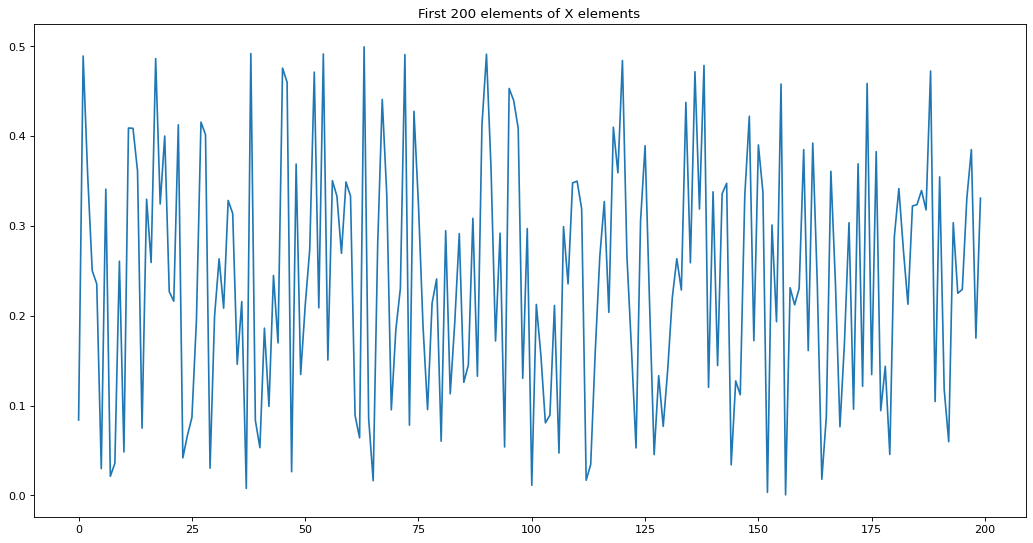

In [34]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(NARMA10_X[:200])
plt.show()

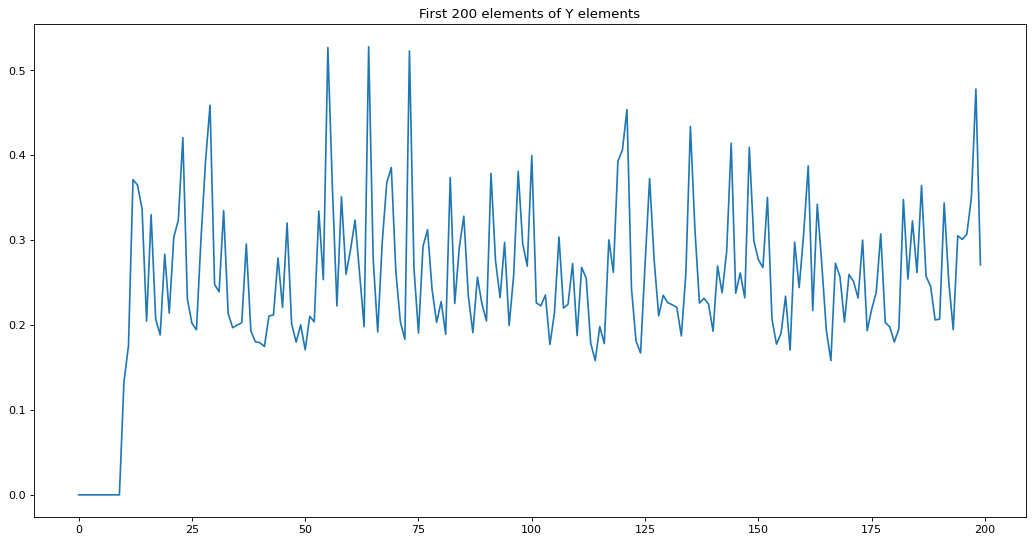

In [35]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(NARMA10_y[:200])
plt.show()

In [36]:
# train split
X_train = NARMA10_X[:4000]
y_train = NARMA10_y[:4000]

# valid split
X_valid = NARMA10_X[4000:5000]
y_valid = NARMA10_y[4000:5000]

Grid search for Echo State Network over NARMA10 dataset.
I will search over:
- dimensionality of hidden layer (hidden_dim).
- spectral radius of the recurren matrix (spectral_radius).
- range of the input-matrix's values (delta_x).
- range of the input-bias-matrix's values (delta_b).
- number of step taken for the transient (transient_lenght).
- reguralization parameter of the readout layer (lambda_reg).

In [37]:
grid = {
    "hidden_dim" : [10, 100],
    "spectral_radius" : [0.3, 0.9],
    "delta_x" : [0.1, 0.5],
    "delta_b" : [0.1, 0.5],
    "transient_lenght" : [100],
    "lambda_reg" : [0, 0.01]
}

train_loss, valid_loss, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 0.00440205931815837 valid loss 0.00448502927084633
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.004478709456789418 valid loss 0.004536566189319871
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0} train loss 0.004397548181931137 valid loss 0.0044957608829840805
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.00452427693922862 valid loss 0.004592705126479186
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.5, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 0.004394403627481519 valid loss 0.00450197056414495
 -- finished {'hidden_dim':

In [38]:
NARMA10_TDNN_valid_loss = valid_loss

In [39]:
# test split
X_test = NARMA10_X[5000:]
y_test = NARMA10_y[5000:]

# train split
X_train = NARMA10_X[:5000]
y_train = NARMA10_y[:5000]

In [40]:
# best parameters of the ESN for the NARMA10 dataset.
best_params

{'hidden_dim': 100,
 'spectral_radius': 0.9,
 'delta_x': 0.1,
 'delta_b': 0.5,
 'transient_lenght': 100,
 'lambda_reg': 0}

In [41]:
# compute the average of train and test error
train_loss, test_loss = multiple_eval(best_params, X_train, y_train, X_test, y_test)

In [42]:
NARMA10_TDNN_train_loss = train_loss
NARMA10_TDNN_test_loss = test_loss

In [43]:
print("NARMA10 Losses")
print("-- MSE Train", NARMA10_TDNN_train_loss)
print("-- MSE Valid", NARMA10_TDNN_valid_loss)
print("-- MSE Test", NARMA10_TDNN_test_loss)

NARMA10 Losses
-- MSE Train 0.00025559046426824097
-- MSE Valid 0.00024274927877693107
-- MSE Test 0.0002740582305081576


In [44]:
esn = EchoStateNetwork(1, **best_params)
esn.train(X_train, y_train)

In [45]:
# Save model
save_stuffs(esn, "Objects/esn_narma10.pkl")

In [46]:
# Load model
# esn = load_stuffs("Objects/esn_narma10.pkl")

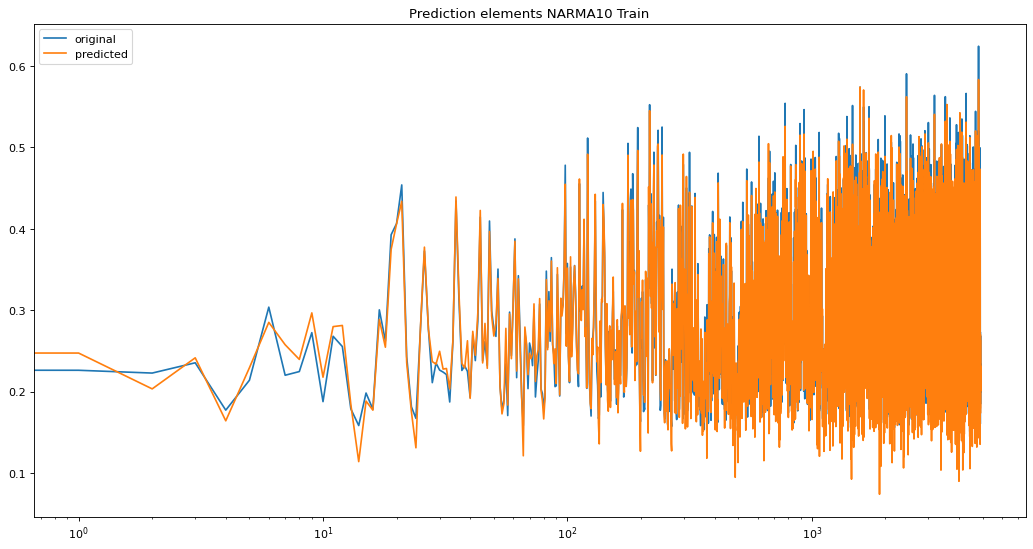

In [47]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = esn.predict(NARMA10_X)
plt.title("Prediction elements NARMA10 Train")
plt.semilogx(NARMA10_y[100:5000], label="original") # remove the transient
plt.semilogx(y_pred[100:5000], label="predicted") # remove the transient
plt.legend()
plt.savefig("Images/NARMA10_Train_Pred")
plt.show()

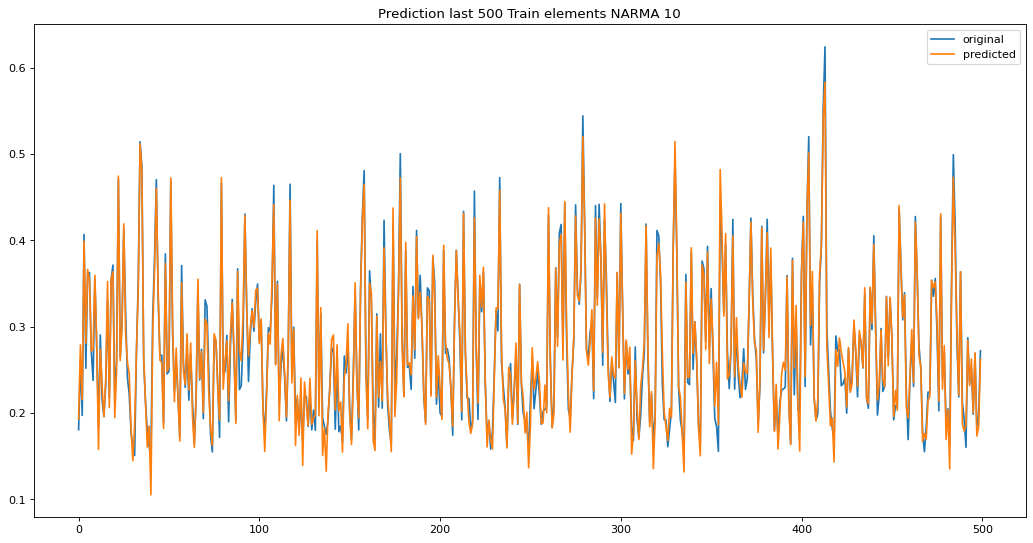

In [48]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Train elements NARMA 10")
plt.plot(NARMA10_y[4500:5000], label="original")
plt.plot(y_pred[4500:5000], label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_Train_Pred2")
plt.show()

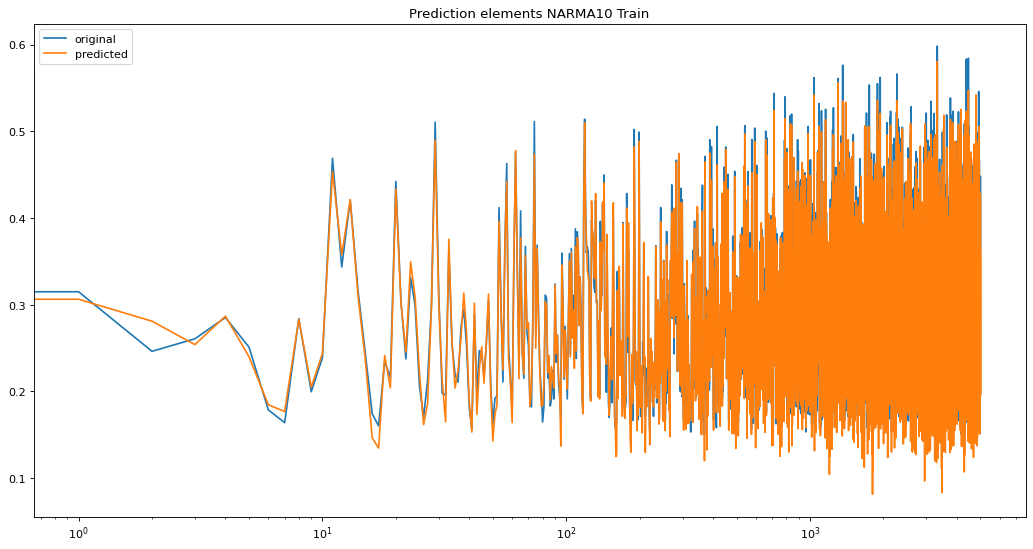

In [49]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction elements NARMA10 Train")
plt.semilogx(NARMA10_y[5000:], label="original")
plt.semilogx(y_pred[5000:], label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_Test_Pred")
plt.show()

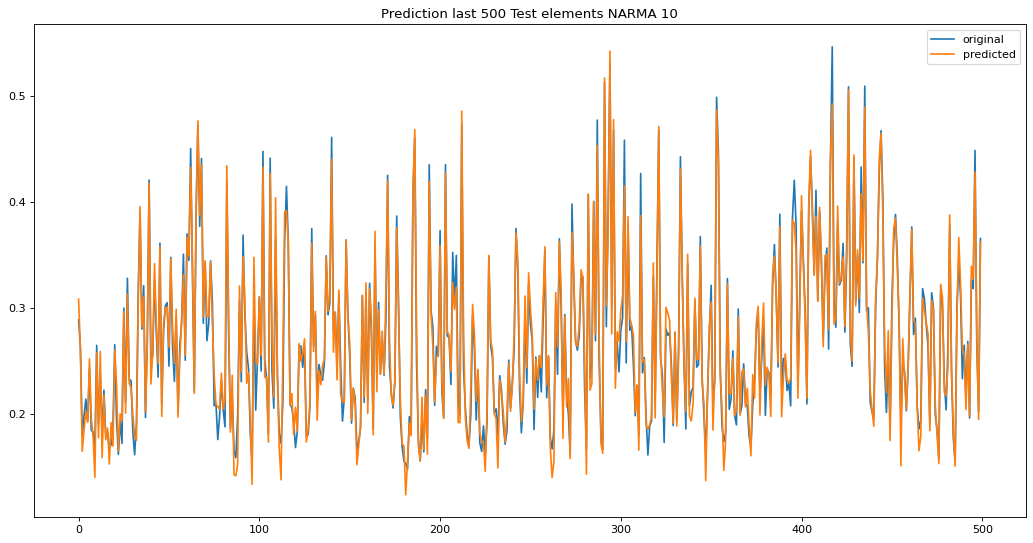

In [50]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Test elements NARMA 10")
plt.plot(NARMA10_y[-500:], label="original")
plt.plot(y_pred[-500:], label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_Test_Pred2")
plt.show()

## MG-17

In [51]:
data_mg17 = pd.read_csv("data/MG17.csv", header=None)

In [52]:
data_mg17.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.032164,0.040426,0.057861,0.084015,0.11544,0.14572,0.16758,0.17624,0.17107,0.15465,...,-0.43905,-0.43957,-0.42772,-0.40213,-0.36305,-0.31286,-0.25555,-0.19556,-0.1368,-0.082192


In [53]:
data = data_mg17.values[0, :]

MG17_X = data[:-1]
MG17_y = data[1:]

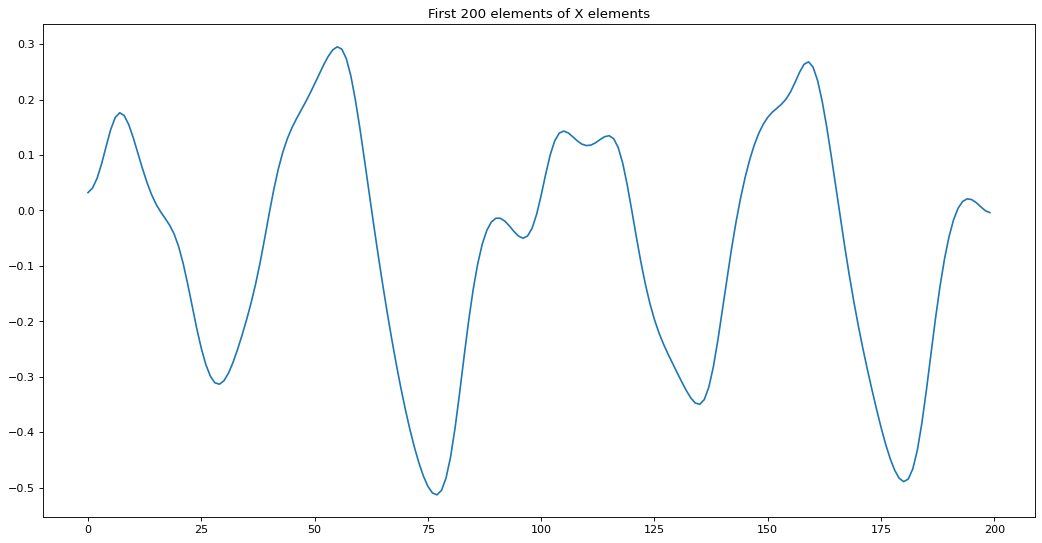

In [54]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(MG17_X[:200])
plt.show()

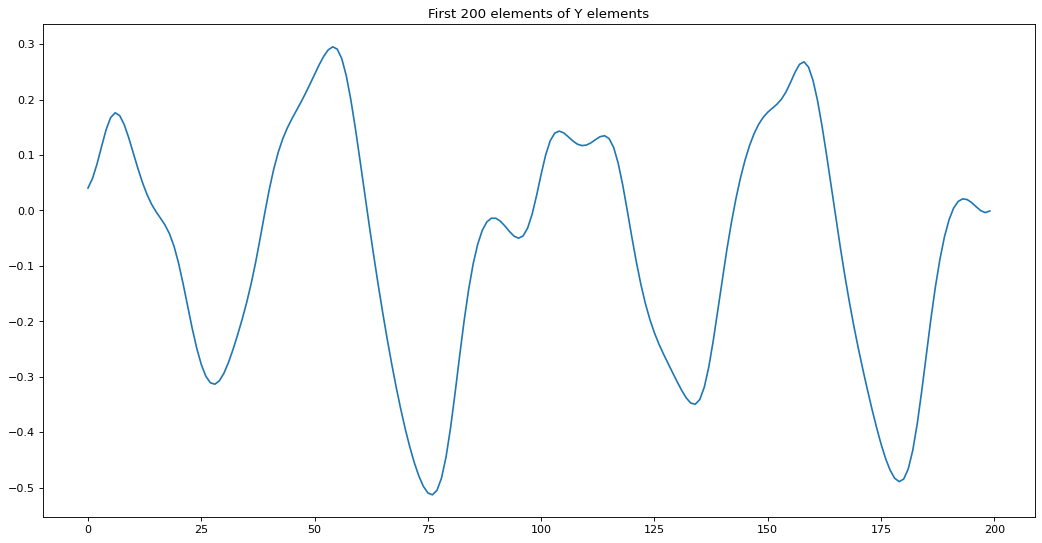

In [55]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(MG17_y[:200])
plt.show()

In [56]:
# train split
X_train = MG17_X[:4000]
y_train = MG17_y[:4000]

# valid split
X_valid = MG17_X[4000:5000]
y_valid = MG17_y[4000:5000]

Grid search for Echo State Network over MG17 dataset.
I will search over:
- dimensionality of hidden layer (hidden_dim).
- spectral radius of the recurren matrix (spectral_radius).
- range of the input-matrix's values (delta_x).
- range of the input-bias-matrix's values (delta_b).
- number of step taken for the transient (transient_lenght).
- reguralization parameter of the readout layer (lambda_reg).

In [57]:
grid = {
    "hidden_dim" : [10, 100],
    "spectral_radius" : [0.3, 0.9],
    "delta_x" : [0.1, 0.5],
    "delta_b" : [0.1, 0.5],
    "transient_lenght" : [100],
    "lambda_reg" : [0, 0.01]
}

train_loss, valid_loss, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 2.3818377307676634e-07 valid loss 2.150338094098503e-07
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.000341117449940318 valid loss 0.00034451703121660864
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0} train loss 2.567883212765746e-06 valid loss 2.5364682635318727e-06
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.0003302417237664937 valid loss 0.0003335508801773807
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.5, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 4.3172531100564e-07 valid loss 3.974503781387274e-07
 -- finished {

In [58]:
MG17_valid_loss = valid_loss

In [59]:
# test split
X_test = MG17_X[5000:]
y_test = MG17_y[5000:]

# train split
X_train = MG17_X[:5000]
y_train = MG17_y[:5000]

In [60]:
# best parameters of the ESN for the NARMA10 dataset.
best_params

{'hidden_dim': 100,
 'spectral_radius': 0.9,
 'delta_x': 0.5,
 'delta_b': 0.1,
 'transient_lenght': 100,
 'lambda_reg': 0}

In [61]:
# compute the average of train and test error
train_loss, test_loss = multiple_eval(best_params, X_train, y_train, X_test, y_test)

In [62]:
MG17_train_loss = train_loss
MG17_test_loss = test_loss

In [63]:
print("MG17 Losses")
print("-- MSE Train", MG17_train_loss)
print("-- MSE Valid", MG17_valid_loss)
print("-- MSE Test", MG17_test_loss)

MG17 Losses
-- MSE Train 5.499794461918106e-08
-- MSE Valid 9.135955566607685e-09
-- MSE Test 5.5288563397901214e-08


In [64]:
esn = EchoStateNetwork(1, **best_params)
esn.train(X_train, y_train)

In [65]:
# Save model
save_stuffs(esn, "Objects/esn_mg17.pkl")

In [66]:
# Load model
# esn = load_stuffs("Objects/esn_mg17.pkl")

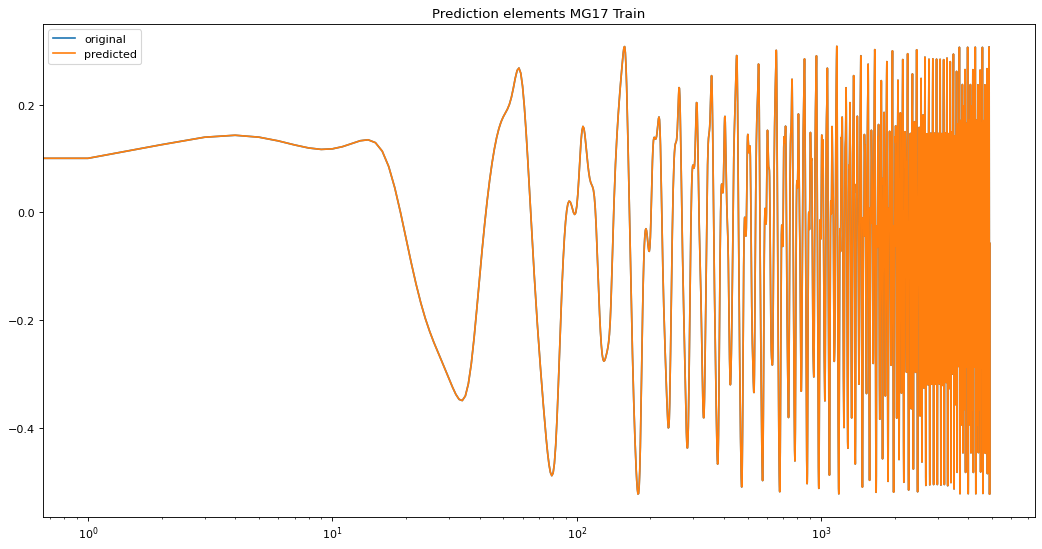

In [67]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = esn.predict(MG17_X)
plt.title("Prediction elements MG17 Train")
plt.semilogx(MG17_y[100:5000], label="original") # remove the transient
plt.semilogx(y_pred[100:5000], label="predicted") # remove the transient
plt.legend()
plt.savefig("Images/MG17_Train_Pred")
plt.show()

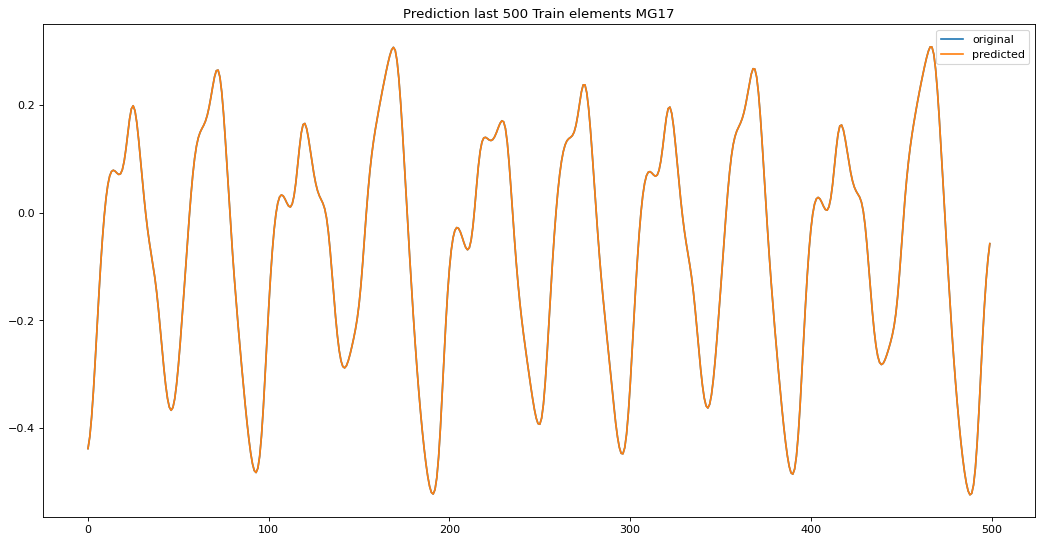

In [68]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Train elements MG17")
plt.plot(MG17_y[4500:5000], label="original")
plt.plot(y_pred[4500:5000], label="predicted")
plt.legend()
plt.savefig("Images/MG17_Train_Pred2")
plt.show()

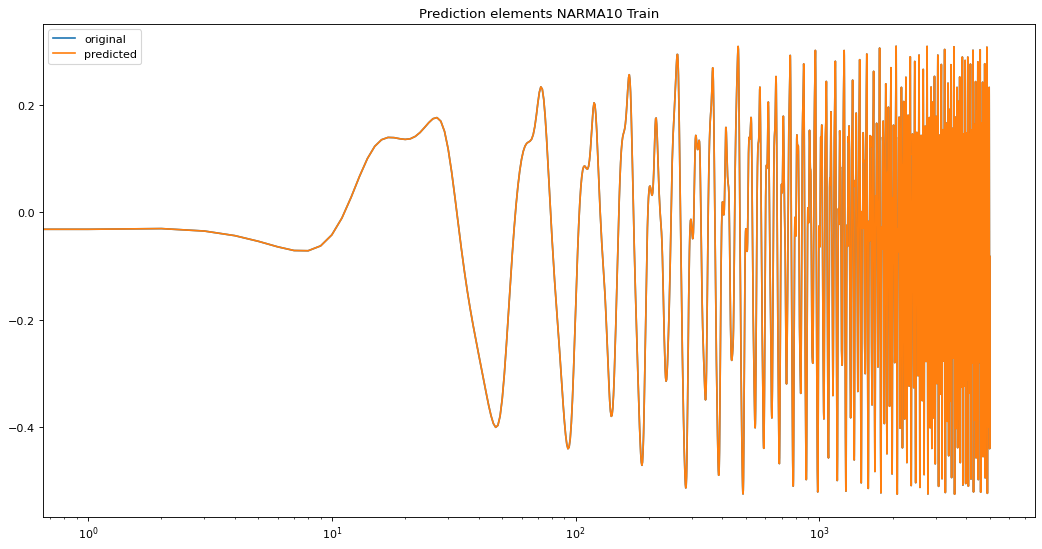

In [69]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction elements NARMA10 Train")
plt.semilogx(MG17_y[5000:], label="original")
plt.semilogx(y_pred[5000:], label="predicted")
plt.legend()
plt.savefig("Images/MG17_Test_Pred")
plt.show()

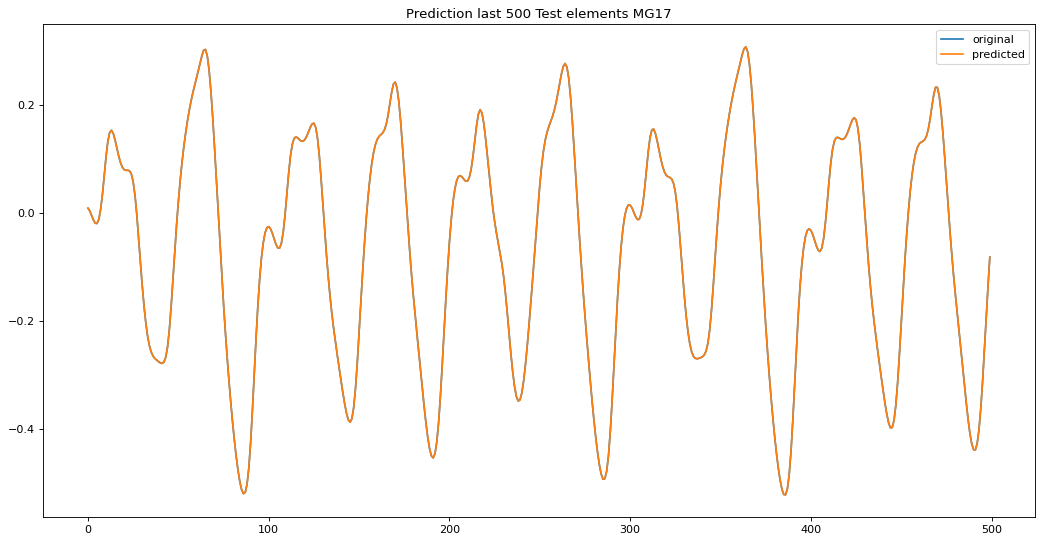

In [70]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Test elements MG17")
plt.plot(MG17_y[-500:], label="original")
plt.plot(y_pred[-500:], label="predicted")
plt.legend()
plt.savefig("Images/MG17_Test_Pred2")
plt.show()

In [71]:
# zip the folders and download the data

!zip -r Images.zip Images/ 
!zip -r Objects.zip Objects/ 

  adding: Images/ (stored 0%)
  adding: Images/MG17_Train_Pred2.png (deflated 4%)
  adding: Images/MG17_Test_Pred2.png (deflated 4%)
  adding: Images/NARMA10_Test_Pred2.png (deflated 3%)
  adding: Images/NARMA10_Train_Pred2.png (deflated 3%)
  adding: Images/NARMA10_Test_Pred.png (deflated 4%)
  adding: Images/MG17_Train_Pred.png (deflated 4%)
  adding: Images/NARMA10_Train_Pred.png (deflated 4%)
  adding: Images/MG17_Test_Pred.png (deflated 4%)
  adding: Objects/ (stored 0%)
  adding: Objects/esn_mg17.pkl (deflated 5%)
  adding: Objects/esn_narma10.pkl (deflated 5%)
